<a href="https://colab.research.google.com/github/gimquokka/ML/blob/master/TF_tutorial_Text_classification_with_preprocessed_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with preprocessed text: Movie reviews 🤥

## Setup

In [1]:
import tensorflow as tf

from tensorflow import  keras

import tensorflow_datasets as tfds

import numpy as np

print(tf.__version__)

2.2.0


## Download the IMDB tfds

In [0]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords32k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True
    )

## Try to encode using encoder in info(tfds)

In [0]:
# ?info

In [4]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=32650>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Po

In [5]:
print(info.description)

Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.


In [0]:
encoder = info.features['text'].encoder #SubwordTextEncoder has method encoder, decoder

In [7]:
print('Vovabulary size : {}'.format(encoder.vocab_size))

Vovabulary size : 32650


In [8]:
sample_string = 'Keep Going!'

encoded_string = encoder.encode(sample_string)
print(encoded_string)

decoded_string = encoder.decode(encoded_string)
assert decoded_string == sample_string
print(decoded_string)

[9326, 32108, 32497, 32427]
Keep Going!


In [9]:
for es in encoded_string:
  print('{} ======> {}'.format(es, encoder.decode([es])))

9326 ======> Keep 
32108 ======> Goin
32497 ======> g
32427 ======> !


## Explore the data

In [10]:
train_example_batch = np.array([[]])
train_label_batch = np.array([])

for train_example, train_label in train_data.take(1):
  print('train_example: \n', train_example[:10])
  print()
  print('train_example_batch.shape \n', train_example.shape)
  print()
  print('train_label_batch \n', train_label)
  print()

train_example: 
 tf.Tensor([   56    18    41   496   674    59     3   574 32433    25], shape=(10,), dtype=int64)

train_example_batch.shape 
 (143,)

train_label_batch 
 tf.Tensor(0, shape=(), dtype=int64)



In [11]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [30]:
# Test shuffle! method
samples = [1, 2, 3, 4, 5, 6]
labels = [1, 2, 3, 4, 5, 6]

test_dataset = tf.data.Dataset.from_tensor_slices((samples, labels))

test_dataset_batches = (
    test_dataset
    .shuffle(2)
    .padded_batch(2)
)

for s, l in test_dataset_batches.take(3):
  print('sample Batch shape: ', s.shape)
  print('sample Batch \n', s)
  print('label shape: ', l.shape)
  print('label \n', s)

sample Batch shape:  (2,)
sample Batch 
 tf.Tensor([1 3], shape=(2,), dtype=int32)
label shape:  (2,)
label 
 tf.Tensor([1 3], shape=(2,), dtype=int32)
sample Batch shape:  (2,)
sample Batch 
 tf.Tensor([4 2], shape=(2,), dtype=int32)
label shape:  (2,)
label 
 tf.Tensor([4 2], shape=(2,), dtype=int32)
sample Batch shape:  (2,)
sample Batch 
 tf.Tensor([6 5], shape=(2,), dtype=int32)
label shape:  (2,)
label 
 tf.Tensor([6 5], shape=(2,), dtype=int32)


## Prepare the data for training model

In [0]:
BUFFER_SIZE = 1000

train_batchs = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [31]:
for s, l in test_batches.take(1):
  print('sample Batch shape: ', s.shape)
  print('sample Batch \n', s)
  print('label shape: ', l.shape)
  print('label \n', l)

sample Batch shape:  (32, 695)
sample Batch 
 tf.Tensor(
[[  156    29   168 ...     0     0     0]
 [  122  1975   187 ...     0     0     0]
 [ 6612  1863 32443 ... 10299   222 32440]
 ...
 [10129  7900 13957 ...     0     0     0]
 [  628     2    12 ...     0     0     0]
 [   12   259    14 ...     0     0     0]], shape=(32, 695), dtype=int64)
label shape:  (32,)
label 
 tf.Tensor([1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1], shape=(32,), dtype=int64)


## Build the model

In [32]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 32),
  keras.layers.GlobalAvgPool1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1044800   
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,044,833
Trainable params: 1,044,833
Non-trainable params: 0
_________________________________________________________________


### Hidden units

### Loss function and optimizer

In [0]:
model.compile(optimizer='adam',
             loss=tf.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

## Train the model

In [35]:
history = model.fit(train_batchs,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 15s 19ms/step - loss: 0.6693 - accuracy: 0.5073 - val_loss: 0.6319 - val_accuracy: 0.5365
Epoch 2/10
782/782 [==============================] - 15s 19ms/step - loss: 0.5613 - accuracy: 0.6364 - val_loss: 0.5318 - val_accuracy: 0.7198
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 0.4542 - accuracy: 0.7719 - val_loss: 0.4584 - val_accuracy: 0.7875
Epoch 4/10
782/782 [==============================] - 15s 19ms/step - loss: 0.3773 - accuracy: 0.8358 - val_loss: 0.4141 - val_accuracy: 0.7990
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.3241 - accuracy: 0.8708 - val_loss: 0.3832 - val_accuracy: 0.8521
Epoch 6/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2856 - accuracy: 0.8911 - val_loss: 0.3651 - val_accuracy: 0.8646
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2518 - accuracy: 0.9056 - val_loss: 0.3536 - val_accuracy:

## Evaluate the model

In [36]:
loss, accuracy = model.evaluate(test_batches)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3025 - accuracy: 0.8634
Loss:  0.3024882972240448
Accuracy:  0.8633999824523926


## Visualize the evaluation result with matplotlib

In [40]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [43]:
print(history_dict['loss'])
print(history_dict['accuracy'])
print(history_dict['val_loss'])
print(history_dict['val_accuracy'])

[0.6693195104598999, 0.5613390207290649, 0.45415452122688293, 0.3773426115512848, 0.3240654468536377, 0.28562086820602417, 0.2517958879470825, 0.22713826596736908, 0.20535162091255188, 0.1839940845966339]
[0.5072799921035767, 0.6363999843597412, 0.7718799710273743, 0.8357599973678589, 0.8707600235939026, 0.8911200165748596, 0.9056400060653687, 0.9172000288963318, 0.926360011100769, 0.936680018901825]
[0.6319437623023987, 0.5318410992622375, 0.4584323763847351, 0.41411760449409485, 0.3832227885723114, 0.3651006519794464, 0.3536212742328644, 0.34655845165252686, 0.34499070048332214, 0.34309276938438416]
[0.5364583134651184, 0.7197916507720947, 0.7875000238418579, 0.7989583611488342, 0.8520833253860474, 0.8645833134651184, 0.8604166507720947, 0.8645833134651184, 0.859375, 0.8614583611488342]


In [0]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

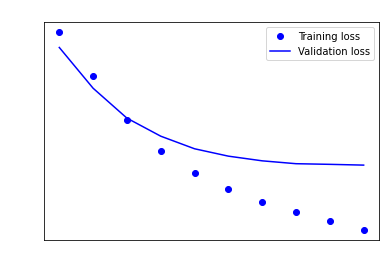

In [65]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss', )
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Traing and validation loss', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Loss', color='white')
plt.rc_context({'xtick.color':'white', 'ytick.color':'white'})
plt.legend()

plt.show()

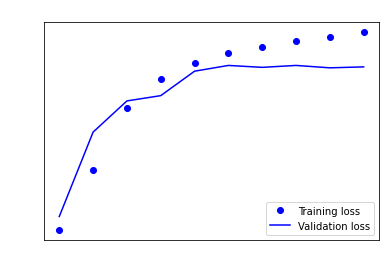

In [63]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training loss', )
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Traing and validation loss', color='white')
plt.xlabel('Epochs', color='white')
plt.ylabel('Accuracy', color='white')
plt.legend(loc='lower right')
plt.rc_context({'xtick.color':'white', 'ytick.color':'white'})

plt.show()